In [1]:
from pathlib import Path
from typing import Union
import evaluate
import pandas as pd
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchmetrics
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk, DatasetDict, load_dataset, Dataset, ClassLabel
import torchaudio
import torchaudio.transforms as T
import random
import torchcodec
import torchaudio
import librosa
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from transformers import TrainingArguments, ASTConfig, ASTForAudioClassification, ASTFeatureExtractor, Trainer
from IPython.display import Audio as AudioDisplay

NUM_PROC = 48
SEED = 42
SAMPLE_RATE = 16000
BATCH_SIZE = 32
NUM_WORKERS = 24
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


/home/pierre/Documents/Projects/PST4/AI/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Dataset from huggingface of drones/others
#ds = load_dataset("Hibou-Foundation/big_ds_preprocessed_spectogram_1").with_format("torch")
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
ds_test_online2 = load_dataset("Usernameeeeee/drone_test_2", split="test")
ds = load_dataset("Hibou-Foundation/ds_10_raw_aug_0-5_balanced_chunked").with_format("torch")

In [4]:
print("Dataset loaded successfully!")
LABELS = ds["train"].features["label"]
id2labels = {i: v for i,v in enumerate(LABELS.names)}
print(f"\nDataset splits:")
for split in ds.keys():
    print(f"\t{split}: {len(ds[split])} samples")

print(f"\nFeatures:")
print(ds["train"].features)


Dataset loaded successfully!

Dataset splits:
	train: 527777 samples
	val: 42198 samples
	test: 44844 samples

Features:
{'audio': List(Value('float32')), 'label': ClassLabel(names=['other', 'drone'])}


In [6]:
# Check a sample
sample = ds["train"][0]
print(f"\nSample data:")
print(f"\tLabel: {sample['label']} ({LABELS.names[sample['label']]})")
AudioDisplay(sample['audio'], rate=16000)


Sample data:
	Label: 0 (other)


In [7]:
def swap_labels(example):
    example["label"] = 1 - example["label"]   # flips 0 ↔ 1
    return example

ds_test_online = ds_test_online.map(swap_labels).with_format("torch")
ds_test_online2 = ds_test_online2.map(swap_labels).with_format("torch")

In [8]:
def collate_fn(batch):
    # Convert Python lists → tensors (2D each)
    return torch.stack([b["audio"] for b in batch]), torch.tensor([b["label"] for b in batch])

train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(ds["val"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, collate_fn=collate_fn)

test_loader1 = DataLoader(ds_test_online, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader2 = DataLoader(ds_test_online2, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [9]:
# we define which pretrained model we want to use and instantiate a feature extractor
pretrained_model = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = ASTFeatureExtractor.from_pretrained(pretrained_model)
# we save model input name and sampling rate for later use
model_input_name = feature_extractor.model_input_names[0]  # key -> 'input_values'
SAMPLING_RATE = feature_extractor.sampling_rate
print(f"Model input name: {model_input_name}")

Model input name: input_values


In [10]:
def preprocess_audio(batch):
    wavs = [audio for audio in batch["input_values"]]
    # inputs are spectrograms as torch.tensors now
    inputs = feature_extractor(wavs, sampling_rate=SAMPLING_RATE, return_tensors="pt")

    output_batch = {model_input_name: inputs.get(model_input_name), "label": list(batch["label"])}
    return output_batch

In [11]:
dataset = ds.rename_column("audio", "input_values")  # rename audio column
dataset.set_transform(preprocess_audio, output_all_columns=False)

In [12]:
# calculate values for normalization
feature_extractor.do_normalize = False  # we set normalization to False in order to calculate the mean + std of the dataset

# we use the transformation w/o augmentation on the training dataset to calculate the mean + std
dataset["train"].set_transform(preprocess_audio, output_all_columns=False)


In [13]:
mean = np.mean([torch.mean(elem) for elem in ds["train"]["audio"]])
std = np.std([torch.std(elem) for elem in ds["train"]["audio"]])

print(f"Mean: {mean}, std: {std}")


Mean: 0.0018884849268943071, std: 0.1126335933804512


In [14]:
feature_extractor.mean = mean
feature_extractor.std = std
feature_extractor.do_normalize = True

In [15]:
from IPython.display import Audio
from matplotlib.patches import Rectangle

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = 1, 8000
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")


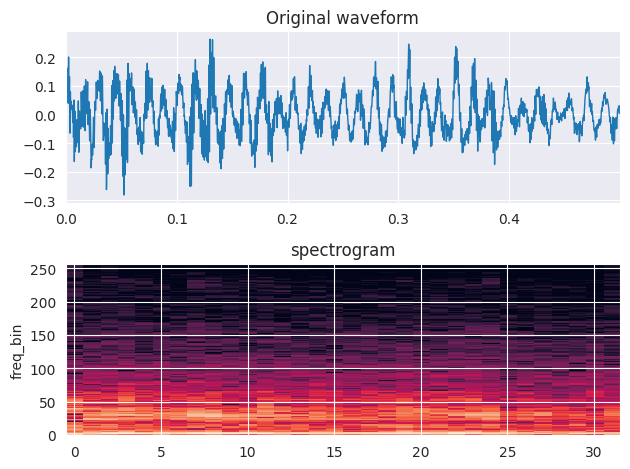

In [16]:
def test():
    # Define transform
    spectrogram = T.Spectrogram(n_fft=512)

    # Perform transform
    spec = spectrogram(ds["train"]["audio"][0])

    fig, axs = plt.subplots(2, 1)
    plot_waveform(ds["train"]["audio"][0], 16000, title="Original waveform", ax=axs[0])
    plot_spectrogram(spec, title="spectrogram", ax=axs[1])
    fig.tight_layout()

test()


In [17]:
label2id = {LABELS.names[i]: i for i in range(len(LABELS.names))}

# Load configuration from the pretrained model
config = ASTConfig.from_pretrained(pretrained_model)
config.num_labels = len(LABELS.names)
config.label2id = label2id
config.id2label = {v: k for k, v in label2id.items()}
# Initialize the model with the updated configuration
model = ASTForAudioClassification.from_pretrained(pretrained_model, config=config, ignore_mismatched_sizes=True)
model.init_weights()

Loading weights: 100%|██████████| 203/203 [00:00<00:00, 2143.16it/s, Materializing param=audio_spectrogram_transformer.embeddings.cls_token]                            
ASTForAudioClassification LOAD REPORT from: MIT/ast-finetuned-audioset-10-10-0.4593
Key                     | Status   |                                                                                       
------------------------+----------+---------------------------------------------------------------------------------------
classifier.dense.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([527]) vs model:torch.Size([2])          
classifier.dense.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([527, 768]) vs model:torch.Size([2, 768])
classifier.dense.weight | MISC     | 'Linear' object has no attribute 'param_name'
Error when processing parameter cl      
classifier.dense.bias   | MISC     | 'Linear' object has no attribute 'param_name'
Error when processing parameter cl      

No

In [18]:
accuracy = evaluate.load("accuracy")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
f1 = evaluate.load("f1")
AVERAGE = "macro" if config.num_labels > 2 else "binary"

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    predictions = np.argmax(logits, axis=1)
    metrics = accuracy.compute(predictions=predictions, references=eval_pred.label_ids)
    metrics.update(precision.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    metrics.update(recall.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    metrics.update(f1.compute(predictions=predictions, references=eval_pred.label_ids, average=AVERAGE))
    return metrics

In [19]:
# Configure training run with TrainingArguments class
training_args = TrainingArguments(
    output_dir="./runs/ast_classifier",
    logging_dir="./logs/ast_classifier",
    report_to="tensorboard",
    learning_rate=5e-5,  # Learning rate
    push_to_hub=False,
    num_train_epochs=10,  # Number of epochs
    per_device_train_batch_size=8,  # Batch size per device
    eval_strategy="epoch",  # Evaluation strategy
    save_strategy="epoch",
    eval_steps=1,
    save_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_strategy="steps",
    logging_steps=20,
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [20]:
# Setup the trainer
model = model.to("cuda")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,  # Use the metrics function from above
)
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacity of 7.60 GiB of which 60.12 MiB is free. Including non-PyTorch memory, this process has 5.74 GiB memory in use. Of the allocated memory 5.40 GiB is allocated by PyTorch, and 185.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)